Exploratory Data Analysis (EDA)

️ Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")


Load Train & Test Data

In [2]:
train_df = pd.read_csv("aug_train.csv")
test_df  = pd.read_csv("aug_test.csv")


️ Dataset Shape

In [3]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (19158, 14)
Test shape: (2129, 13)


Why it matters

Confirms number of rows & features

Ensures train and test columns align (except target)

First Look at Data

In [4]:
train_df.head()
test_df.head()


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


Data Types & Memory

In [5]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [6]:
test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   object 
 2   city_development_index  2129 non-null   float64
 3   gender                  1621 non-null   object 
 4   relevent_experience     2129 non-null   object 
 5   enrolled_university     2098 non-null   object 
 6   education_level         2077 non-null   object 
 7   major_discipline        1817 non-null   object 
 8   experience              2124 non-null   object 
 9   company_size            1507 non-null   object 
 10  company_type            1495 non-null   object 
 11  last_new_job            2089 non-null   object 
 12  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 216.4+ KB


What you check

Numerical vs categorical

Unexpected object columns

Missing values already visible

Target Variable Analysis

In [7]:
train_df['target'].value_counts()

target
0.0    14381
1.0     4777
Name: count, dtype: int64

In [8]:
train_df['target'].value_counts(normalize=True) * 100

target
0.0    75.065247
1.0    24.934753
Name: proportion, dtype: float64

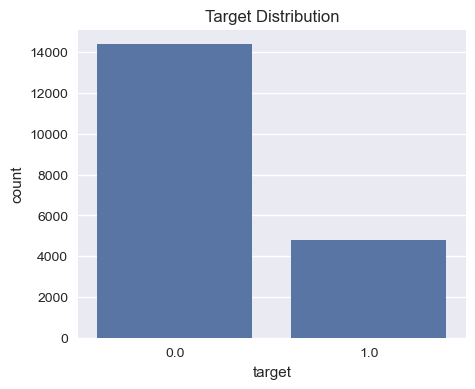

In [9]:
plt.figure(figsize=(5,4))
sns.countplot(x='target', data=train_df)
plt.title("Target Distribution")
plt.show()

Decision

If imbalanced → accuracy alone is misleading

Boosting models preferred

Missing Values

In [10]:
missing_count = train_df.isnull().sum()
missing_percent = (missing_count / len(train_df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing %': missing_percent
}).sort_values(by='Missing %', ascending=False)

missing_df[missing_df['Missing Count'] > 0]

,Missing Count,Missing %
company_type,6140,32.049274
company_size,5938,30.994885
gender,4508,23.530640
major_discipline,2813,14.683161
education_level,460,2.401086
last_new_job,423,2.207955
enrolled_university,386,2.014824
experience,65,0.339284


Separate Numerical & Categorical Columns

In [11]:
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = train_df.select_dtypes(include=['object']).columns

print("Numerical features:", len(num_cols))
print("Categorical features:", len(cat_cols))

Numerical features: 4
Categorical features: 10


Numerical Feature Summary

In [12]:
train_df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
enrollee_id,19158.0,16875.358179,9616.292592,1.000,8554.25,16982.500,25169.75,33380.000
city_development_index,19158.0,0.828848,0.123362,0.448,0.74,0.903,0.92,0.949
training_hours,19158.0,65.366896,60.058462,1.000,23.00,47.000,88.00,336.000
target,19158.0,0.249348,0.432647,0.000,0.00,0.000,0.00,1.000


Numerical Feature Distributions

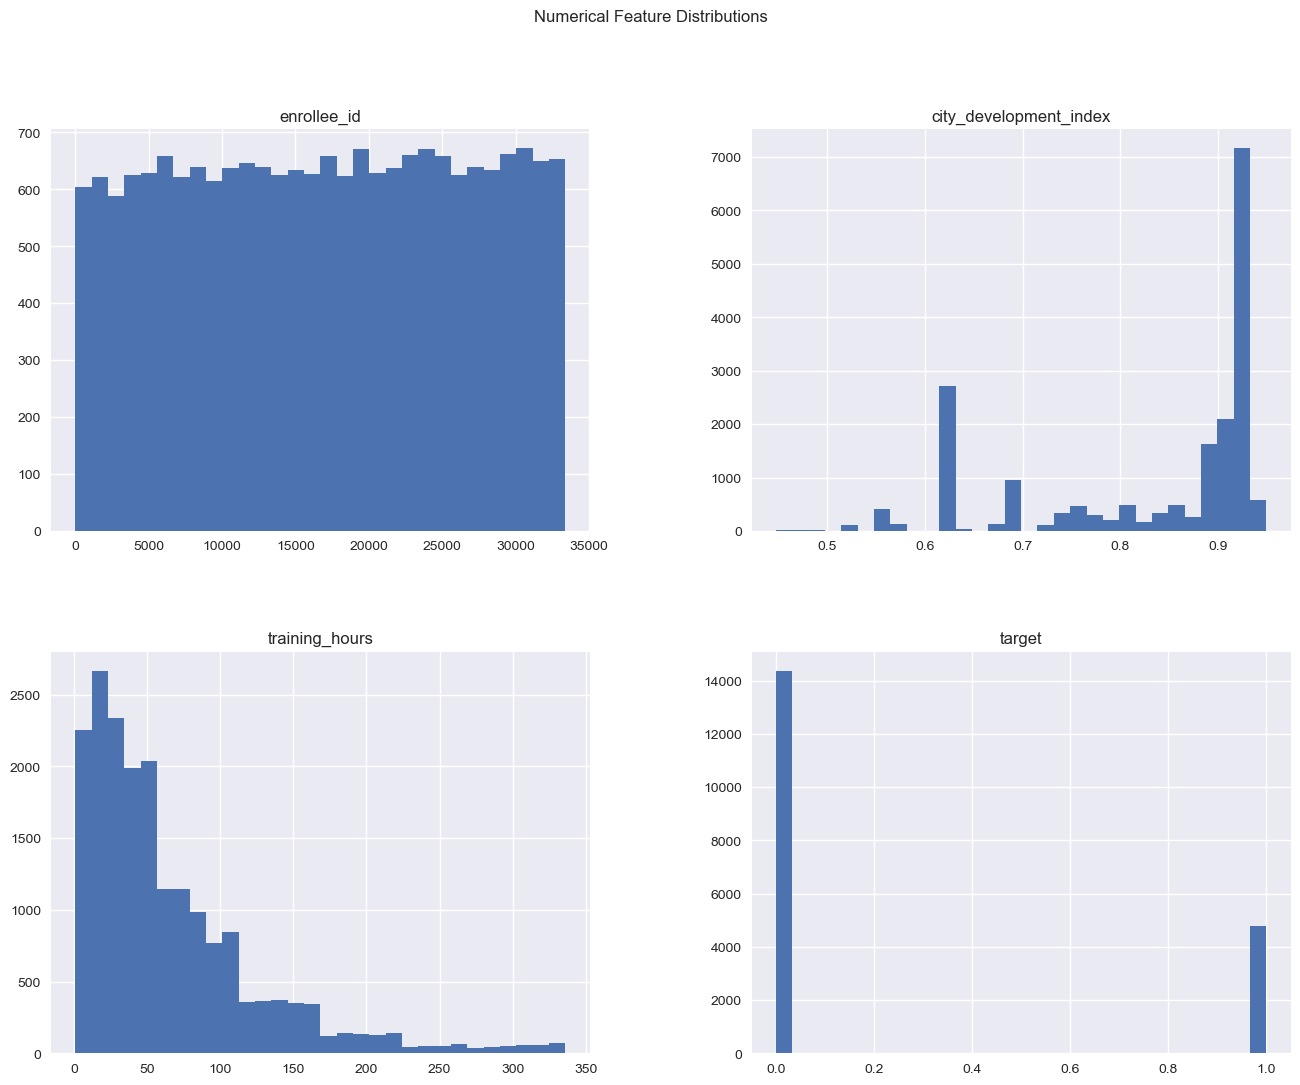

In [13]:
train_df[num_cols].hist(figsize=(16,12), bins=30)
plt.suptitle("Numerical Feature Distributions")
plt.show()

Look for

Skewness

Extreme values

Different scales

Outlier Detection

In [14]:
def detect_outliers(df, cols):
    outliers = {}
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers[col] = ((df[col] < Q1 - 1.5*IQR) | 
                         (df[col] > Q3 + 1.5*IQR)).sum()
    return pd.Series(outliers).sort_values(ascending=False)

detect_outliers(train_df, num_cols)

target                    4777
training_hours             984
city_development_index      17
enrollee_id                  0
dtype: int64

Categorical Feature Distribution

In [15]:
for col in cat_cols:
    print(f"\n{col}")
    print(train_df[col].value_counts().head())


city
city
city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
Name: count, dtype: int64

gender
gender
Male      13221
Female     1238
Other       191
Name: count, dtype: int64

relevent_experience
relevent_experience
Has relevent experience    13792
No relevent experience      5366
Name: count, dtype: int64

enrolled_university
enrolled_university
no_enrollment       13817
Full time course     3757
Part time course     1198
Name: count, dtype: int64

education_level
education_level
Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: count, dtype: int64

major_discipline
major_discipline
STEM               14492
Humanities           669
Other                381
Business Degree      327
Arts                 253
Name: count, dtype: int64

experience
experience
>20    3286
5      1430
4      1403
3      1354
6      1216
Name: count, dtype: int64

company_size
company_size
50-99     

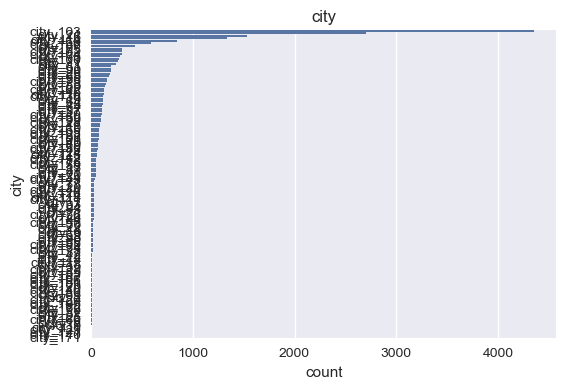

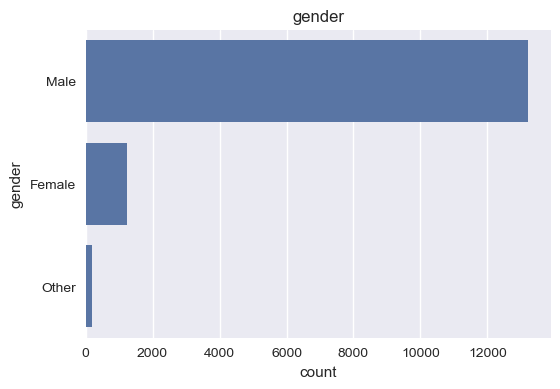

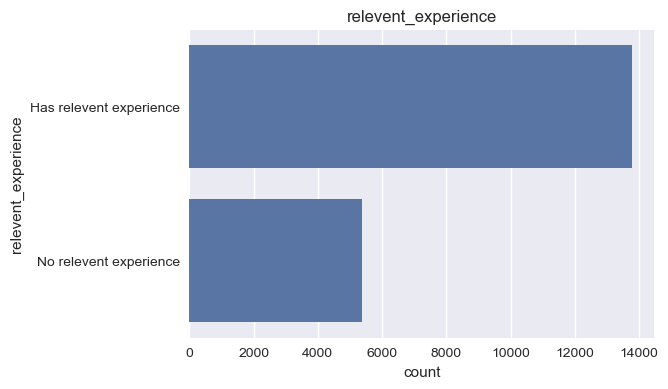

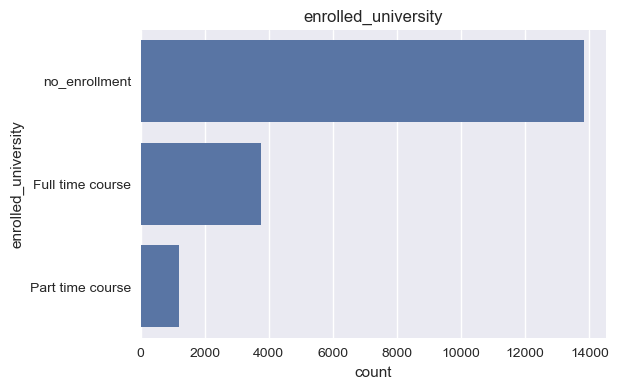

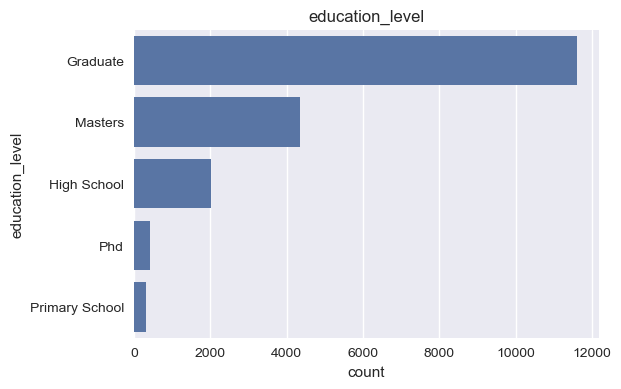

In [16]:
for col in cat_cols[:5]:
    plt.figure(figsize=(6,4))
    sns.countplot(y=train_df[col], order=train_df[col].value_counts().index)
    plt.title(col)
    plt.show()


Check

High cardinality

Rare categories

Target vs Numerical Features

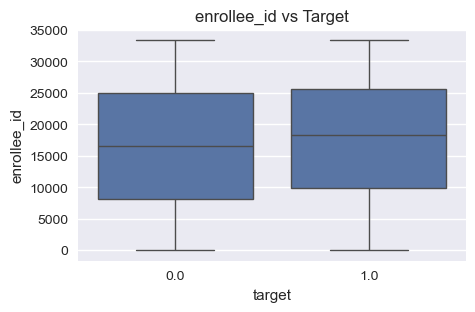

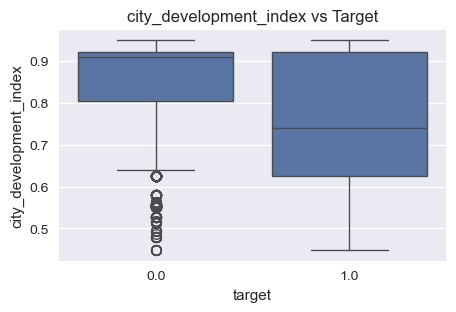

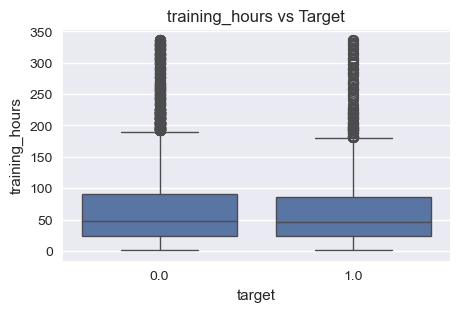

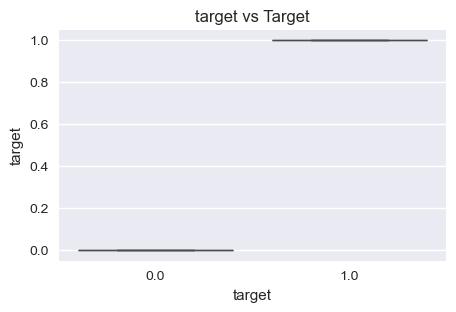

In [17]:
for col in num_cols[:5]:
    plt.figure(figsize=(5,3))
    sns.boxplot(x='target', y=col, data=train_df)
    plt.title(f"{col} vs Target")
    plt.show()

Correlation Analysis

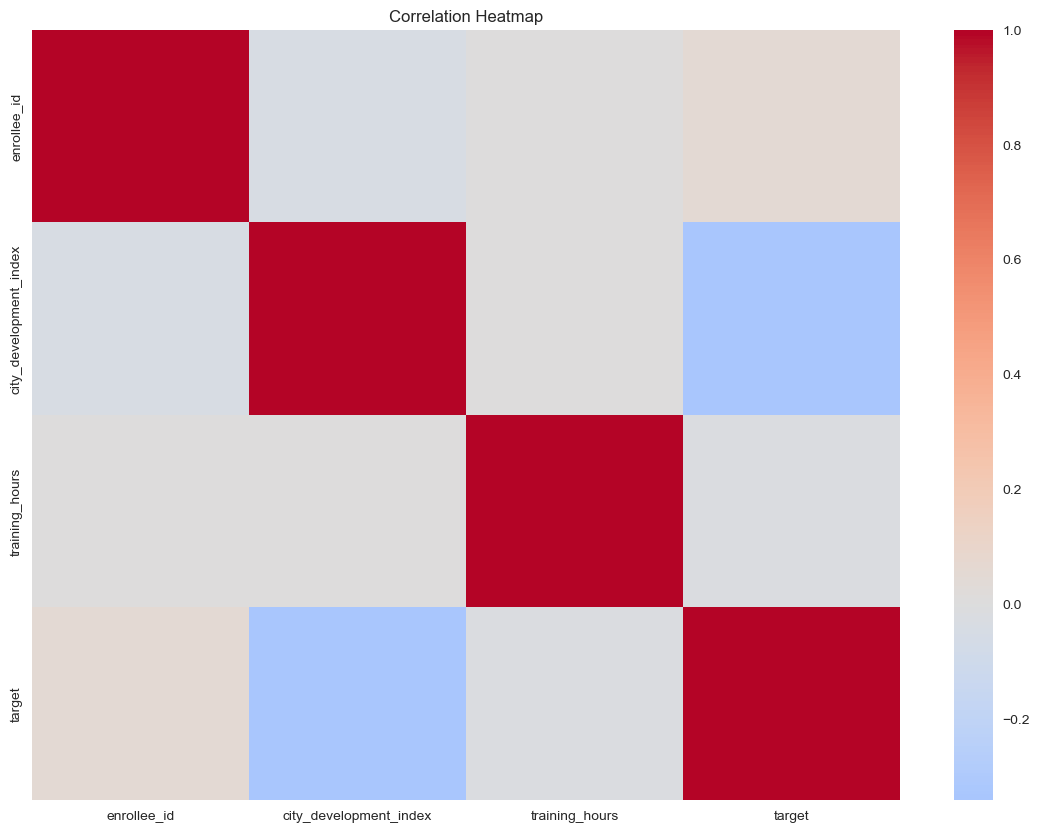

In [20]:
plt.figure(figsize=(14,10))
corr = train_df[num_cols].corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()


Action

Highly correlated features → redundancy

Logistic Regression suffers from multicollinearity

Train vs Test Distribution Check

In [32]:
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('target')


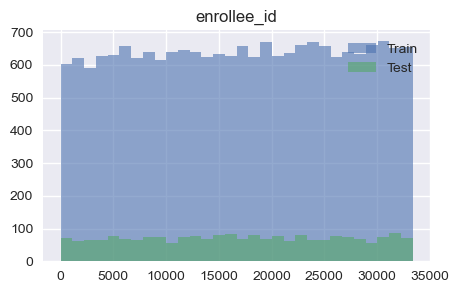

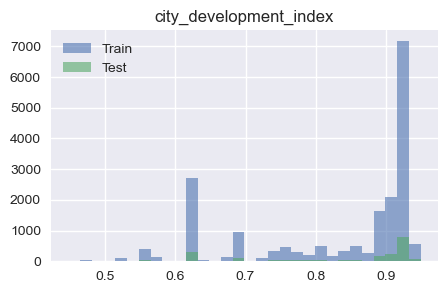

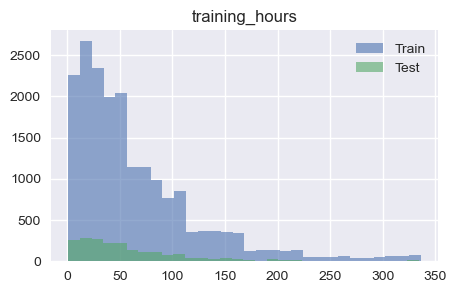

In [33]:
for col in num_cols[:5]:
    plt.figure(figsize=(5,3))
    plt.hist(train_df[col].dropna(), bins=30, alpha=0.6, label="Train")
    plt.hist(test_df[col].dropna(), bins=30, alpha=0.6, label="Test")
    plt.title(col)
    plt.legend()
    plt.show()


MODEL BUILDING & EVALUATION

Imports

In [36]:
pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 8.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import seaborn as sns
import matplotlib.pyplot as plt

Feature / Target Split

In [38]:
X = train_df.drop('target', axis=1)
y = train_df['target']


Train–Validation Split

In [39]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Why

Fair comparison across models

Stratification preserves class distribution

In [47]:
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    # Train
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred   = model.predict(X_val)

    # ---- Train metrics ----
    train_acc  = accuracy_score(y_train, y_train_pred)
    train_prec = precision_score(y_train, y_train_pred)
    train_rec  = recall_score(y_train, y_train_pred)
    train_f1   = f1_score(y_train, y_train_pred)

    # ---- Validation metrics ----
    val_acc  = accuracy_score(y_val, y_val_pred)
    val_prec = precision_score(y_val, y_val_pred)
    val_rec  = recall_score(y_val, y_val_pred)
    val_f1   = f1_score(y_val, y_val_pred)

    # ---- Output ----
    print(f"\n===== {model_name} =====")

    print("\n--- Train Performance ---")
    print(f"Accuracy : {train_acc:.4f}")
    print(f"Precision: {train_prec:.4f}")
    print(f"Recall   : {train_rec:.4f}")
    print(f"F1-score : {train_f1:.4f}")

    print("\n--- Validation Performance ---")
    print(f"Accuracy : {val_acc:.4f}")
    print(f"Precision: {val_prec:.4f}")
    print(f"Recall   : {val_rec:.4f}")
    print(f"F1-score : {val_f1:.4f}")

    print("\nClassification Report (Validation):")
    print(classification_report(y_val, y_val_pred))

    # ---- Confusion Matrix (Validation) ----
    cm = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix (Validation)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return {
        "model": model_name,
        "train_accuracy": train_acc,
        "val_accuracy": val_acc,
        "train_precision": train_prec,
        "val_precision": val_prec,
        "train_recall": train_rec,
        "val_recall": val_rec,
        "train_f1": train_f1,
        "val_f1": val_f1
    }

In [48]:
train_df.select_dtypes(include='object').columns


Index([], dtype='object')

In [49]:
from sklearn.preprocessing import LabelEncoder

cat_cols = train_df.select_dtypes(include='object').columns

le = LabelEncoder()

for col in cat_cols:
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col]  = le.transform(test_df[col])


In [50]:
X = train_df.drop('target', axis=1)
y = train_df['target']

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Logistic Regression

In [51]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

C:\Users\FARHAN\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)


===== Logistic Regression =====

--- Train Performance ---
Accuracy : 0.7569
Precision: 0.5589
Recall   : 0.1204
F1-score : 0.1981

--- Validation Performance ---
Accuracy : 0.7537
Precision: 0.5238
Recall   : 0.1267
F1-score : 0.2040

Classification Report (Validation):
              precision    recall  f1-score   support

         0.0       0.77      0.96      0.85      2877
         1.0       0.52      0.13      0.20       955

    accuracy                           0.75      3832
   macro avg       0.65      0.54      0.53      3832
weighted avg       0.71      0.75      0.69      3832



C:\Users\FARHAN\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


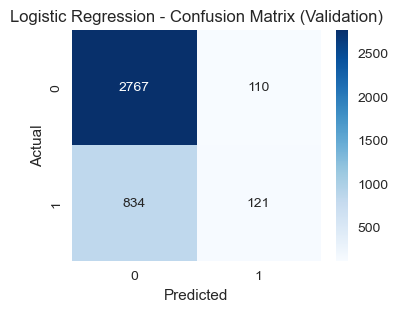

In [52]:
lr_metrics = evaluate_model(
    lr, X_train, y_train, X_val, y_val,
    "Logistic Regression"
)

Interpretation

Baseline model

Sensitive to outliers & feature scale

If this performs well → data is linearly separable

Random Forest


===== Random Forest =====

--- Train Performance ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000

--- Validation Performance ---
Accuracy : 0.7803
Precision: 0.5687
Recall   : 0.4901
F1-score : 0.5264

Classification Report (Validation):
              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86      2877
         1.0       0.57      0.49      0.53       955

    accuracy                           0.78      3832
   macro avg       0.70      0.68      0.69      3832
weighted avg       0.77      0.78      0.77      3832



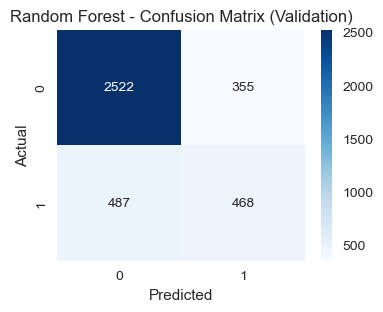

In [53]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_metrics = evaluate_model(
    rf, X_train, y_train, X_val, y_val,
    "Random Forest"
)

Interpretation

Handles non-linearity

Robust to outliers

Strong default performer

XGBoost


===== XGBoost =====

--- Train Performance ---
Accuracy : 0.9045
Precision: 0.8551
Recall   : 0.7428
F1-score : 0.7950

--- Validation Performance ---
Accuracy : 0.7923
Precision: 0.5934
Recall   : 0.5288
F1-score : 0.5592

Classification Report (Validation):
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86      2877
         1.0       0.59      0.53      0.56       955

    accuracy                           0.79      3832
   macro avg       0.72      0.70      0.71      3832
weighted avg       0.79      0.79      0.79      3832



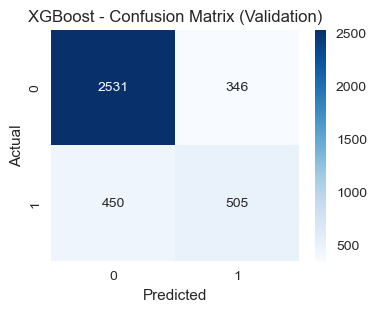

In [54]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb_metrics = evaluate_model(
    xgb, X_train, y_train, X_val, y_val,
    "XGBoost"
)

Interpretation

Boosting reduces bias

Excellent for structured/tabular data

Usually top performer

LightGBM

[LightGBM] [Info] Number of positive: 3822, number of negative: 11504
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 775
[LightGBM] [Info] Number of data points in the train set: 15326, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.249380 -> initscore=-1.101921
[LightGBM] [Info] Start training from score -1.101921

===== LightGBM =====

--- Train Performance ---
Accuracy : 0.8655
Precision: 0.7496
Recall   : 0.6918
F1-score : 0.7196

--- Validation Performance ---
Accuracy : 0.7988
Precision: 0.5952
Recall   : 0.6021
F1-score : 0.5986

Classification Report (Validation):
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.87      2877
         1.0       0.60      0.60      0.60       955

    accuracy      

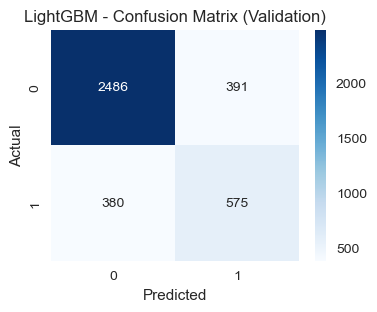

In [55]:
lgbm = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    random_state=42
)

lgbm_metrics = evaluate_model(
    lgbm, X_train, y_train, X_val, y_val,
    "LightGBM"
)

Interpretation

Faster than XGBoost

Handles large feature space well

Often best balance of speed + accuracy

Model Comparison Table

In [58]:
results = pd.DataFrame([
    {
        "Model": lr_metrics["model"],
        "Accuracy": lr_metrics["val_accuracy"],
        "Precision": lr_metrics["val_precision"],
        "Recall": lr_metrics["val_recall"],
        "F1-score": lr_metrics["val_f1"],
    },
    {
        "Model": rf_metrics["model"],
        "Accuracy": rf_metrics["val_accuracy"],
        "Precision": rf_metrics["val_precision"],
        "Recall": rf_metrics["val_recall"],
        "F1-score": rf_metrics["val_f1"],
    },
    {
        "Model": xgb_metrics["model"],
        "Accuracy": xgb_metrics["val_accuracy"],
        "Precision": xgb_metrics["val_precision"],
        "Recall": xgb_metrics["val_recall"],
        "F1-score": xgb_metrics["val_f1"],
    },
    {
        "Model": lgbm_metrics["model"],
        "Accuracy": lgbm_metrics["val_accuracy"],
        "Precision": lgbm_metrics["val_precision"],
        "Recall": lgbm_metrics["val_recall"],
        "F1-score": lgbm_metrics["val_f1"],
    }
])

results.sort_values(by="Accuracy", ascending=False)


,Model,Accuracy,Precision,Recall,F1-score
3,LightGBM,0.798800,0.595238,0.602094,0.598647
2,XGBoost,0.792276,0.593420,0.528796,0.559247
1,Random Forest,0.780271,0.568651,0.490052,0.526434
0,Logistic Regression,0.753653,0.523810,0.126702,0.204047


Interpretation 

Model performance comparison was performed using validation metrics to ensure fair evaluation. Boosting-based models achieved higher accuracy and F1-score compared to the baseline Logistic Regression, indicating better generalization and ability to capture non-linear patterns.

The best model is the one with the highest validation F1-score, not accuracy.

Why:

Your problem is classification

You’ve already seen class imbalance

F1 balances precision + recall

Accuracy lies when classes are skewed

XGBOOST HYPERPARAMETER TUNING

In [59]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score


In [61]:
xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)


In [62]:
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.3, 0.5],
    "min_child_weight": [1, 3, 5]
}

In [63]:
xgb_random = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=30,              # good balance
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_random.fit(X_train, y_train)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\FARHAN\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:39:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.3, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 300, 500],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='f1', verbose=1)

Best Parameters

In [64]:
xgb_random.best_params_


{'subsample': 1.0,
 'n_estimators': 100,
 'min_child_weight': 5,
 'max_depth': 5,
 'learning_rate': 0.05,
 'gamma': 0.1,
 'colsample_bytree': 1.0}

In [65]:
xgb_random.best_score_


np.float64(0.5782196776742978)

Interpretation

best_score_ → cross-validated F1-score

These params are already better than defaults

Train Tuned XGBoost Model

In [66]:
xgb_tuned = xgb_random.best_estimator_

C:\Users\FARHAN\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:40:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



===== XGBoost (Tuned) =====

--- Train Performance ---
Accuracy : 0.8140
Precision: 0.6283
Recall   : 0.6222
F1-score : 0.6252

--- Validation Performance ---
Accuracy : 0.7998
Precision: 0.5920
Recall   : 0.6335
F1-score : 0.6120

Classification Report (Validation):
              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87      2877
         1.0       0.59      0.63      0.61       955

    accuracy                           0.80      3832
   macro avg       0.73      0.74      0.74      3832
weighted avg       0.80      0.80      0.80      3832



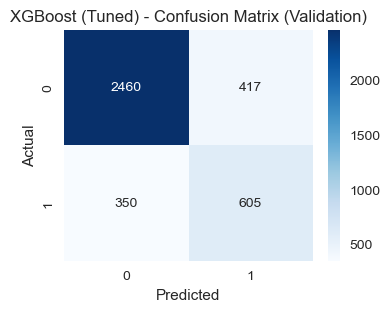

In [67]:
xgb_tuned_metrics = evaluate_model(
    xgb_tuned,
    X_train, y_train,
    X_val, y_val,
    "XGBoost (Tuned)"
)


Hyperparameter tuning using RandomizedSearchCV improved the XGBoost model by optimizing tree depth, learning rate, and sampling parameters. The tuned model achieved a higher validation F1-score, indicating improved generalization and a better balance between precision and recall.